In [1]:
import os, sys, time, resource, re, gc, shutil

mp_pdf = False
if mp_pdf:
    extension = "pdf"
    import matplotlib
    matplotlib.use('pgf')
    pgf_with_latex = {
        "text.usetex": True,            # use LaTeX to write all text
        "pgf.rcfonts": False,           # Ignore Matplotlibrc
        "text.latex.unicode": True,
        "pgf.preamble": [
            #r"\usepackage[utf8x]{inputenc}",
            r"\usepackage{xcolor}"
        ],
        "pgf.texsystem" : "xelatex",
        "figure.figsize": [12,7]
    }
    matplotlib.rcParams.update(pgf_with_latex)
else:
    extension = "png"
    
import operator
from multiprocess import Pool
from functools import partial
from urllib.parse import urlparse, parse_qsl
from django.db.models import Count

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import django
from adjustText import adjust_text

sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from scoping.models import *
from tmv_app.models import *
from django.db.models import F, Sum, Count
from matplotlib import gridspec

from utils.utils import *
from copy import deepcopy


from run_id import run_id

run_id = 1056

run_id = 1429

run_id = 1771
#run_id = 1810
#run_id = 1817

runstat = RunStats.objects.get(pk=run_id)

if runstat.method=="DT":
    topics = DynamicTopic.objects.filter(run_id=run_id)
else:
    topics = Topic.objects.filter(run_id=run_id)

In [2]:
if runstat.method=="DT":
    
    tsums = topics.aggregate(
        ip_score=Sum('ipcc_score'),
        score=Sum('ipcc_time_score')
    )
    tsums
    
    topics.update(
        ipcc_share=F('ipcc_score')/tsums['ip_score'],
        share=F('ipcc_time_score')/tsums['score']
    )
    

In [3]:
def calculate_deviations(df):
    df['deviation'] = df['ipcc_share'] - df['share']
    df['abs_md'] = abs(df['deviation'])

    md = df['deviation'].max()
    rae = df['abs_md'].mean()
    lh = df['abs_md'].sum() / 2

    df['representation'] = df['ipcc_share'] / df['share']  
    
    df_disp = {'MD':md,'Rae':rae,'L-H':lh}
    return [df,df_disp]


In [4]:


if runstat.method=="DT":
    df = pd.DataFrame.from_dict(
        list(topics.values(
            'title',
            'score',
            'ipcc_coverage',
            'share',
            'ipcc_score',
            'ipcc_share',
            'ipcc_time_score',
            'primary_wg'
        ))
    )
else:
    df = pd.DataFrame.from_dict(
        list(topics.values(
            'title',
            'score',
            'ipcc_coverage',
            'share',
            'ipcc_score',
            'ipcc_share',
            'primary_wg'
        ))
    )
    
    
    

df, df_disp  = calculate_deviations(df)


df.sort_values('representation').head()

,ipcc_coverage,ipcc_score,ipcc_share,primary_wg,score,share,title,deviation,abs_md,representation
39,0.022719,3.186839,0.001146,3,286.382796,0.007246,"{hydrogen, catalyst, cell}",-0.006099,0.006099,0.158202
44,0.036333,4.191450,0.001508,3,260.707918,0.006596,"{waste, landfill, treatment}",-0.005089,0.005089,0.228565
75,0.046761,4.649425,0.001672,2,283.264356,0.007167,"{adsorption, capacity, adsorbent}",-0.005494,0.005494,0.233350
10,0.043010,7.954098,0.002861,3,439.285942,0.011114,"{cement, material, concrete}",-0.008253,0.008253,0.257421
0,0.038335,4.114427,0.001480,3,218.514466,0.005529,"{coal, combustion, technology}",-0.004049,0.004049,0.267688


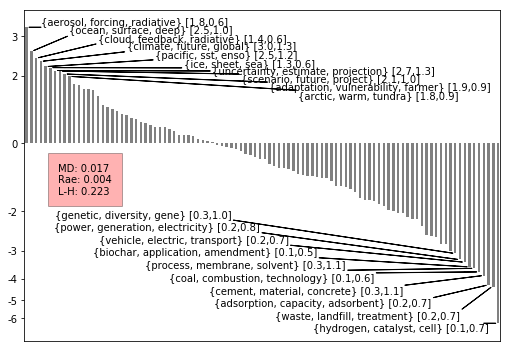

In [5]:

from matplotlib import ticker


plt.rcParams["figure.figsize"] = [7.2,5]

def plot_representation(df, ax, nts=5, xspace=3,yspace = 0.15, fmin=None, fmax=None):
    
    md = df['deviation'].max()
    rae = df['abs_md'].mean()
    lh = df['abs_md'].sum() / 2

    pdf = df.sort_values('representation',ascending=False).reset_index()#.set_index('title')

    pdf = pdf[pdf['share'] > 0.001]

    pdf['lrep'] = np.log(pdf['representation'])
    #pdf['lrep'] = pdf['representation']
    pdf.set_index('title')['lrep'].plot(kind="bar",ax=ax,color="grey")

    i = 0

    rmax = pdf['lrep'].max()
    if fmax:
        rmax = fmax
    rmin = pdf['lrep'].min()
    if fmin:
        rmin = -fmin
    
    for index, row in pdf.head(nts).iterrows():
        i+=1
        s = round(row['ipcc_share']*100,1)
        v = round(row['share']*100,1)
        ax.annotate(
            s="{} [{},{}]".format(row['title'],s,v),
            xy=(-0.5+i,row['lrep']),
            xytext=((xspace-3)*-1+i*xspace,rmax-rmax*yspace*(i-1)),
            arrowprops=dict(
                facecolor='black', 
                #shrink=0.05,
                width=0.1,
                headwidth=0.2
            ),
            ha="left",
            va="bottom"
        )

    i = 0
    for index, row in pdf.sort_values('representation').head(nts).iterrows():
        i+=1
        s = round(row['ipcc_share']*100,1)
        v = round(row['share']*100,1)
        ax.annotate(
            s="{} [{},{}]".format(row['title'],s,v),
            xy=(len(pdf)-0.5-i,row['lrep']),
            xytext=(len(pdf)+xspace-3-i*xspace,rmin-rmin*yspace*(i-1)),
            arrowprops=dict(
                facecolor='black', 
                #shrink=0.05,
                width=0.1,
                headwidth=0.2
            ),
            ha="right",
            va="top"
        )
        
    #ax.set_yscale('log')
    
    
    if rmin > -1:
        rmin = -1
    if np.exp(rmax) < 2:
        rmax = np.log(2.1)
    
    lmin = int(1/np.exp(rmin)//1)*-1
    lmax = int(np.exp(rmax)//1)
    


    ytick_labels = [i for i in range(lmin,lmax+1) if i not in [-1,1]]
    yticks = []
    for x in ytick_labels:
        if x < 0:
            y = np.log(-1/x)
        elif x==0:
            y = 0
        else:
            y = np.log(x)
        yticks.append(y)
    
    ax.set_yticks(yticks)
    ax.set_yticklabels(ytick_labels)
    
    #ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.1f"))
        
    rmax = pdf['lrep'].max()
    rmin = pdf['lrep'].min()
    
    ax.text(
        len(pdf)*0.066,-0.2,
        "MD: {:.3f}\nRae: {:.3f}\nL-H: {:.3f}".format(md,rae,lh),
        va="top",
        ha="left",
        bbox={'facecolor':'red', 'alpha':0.3,'pad':10}
   )

    #ax.text(1,-1*0.2,"MD: {:.3f}".format(md))   
    #ax.text(1,-1*0.4,"Rae: {:.3f}".format(rae))   
    #ax.text(1,-1*0.6,"L-H: {:.3f}".format(lh))   
    
    ax.get_xaxis().set_visible(False)#.set_ticks([])
    
    ax.set_ylim((rmin+rmin*0.1,rmax+rmax*0.15))

fig, ax = plt.subplots()
plot_representation(df,ax,nts=10,xspace=6,yspace=0.07)
plt.tight_layout()
if mp_pdf:
    plt.savefig('../plots/ipcc_representation/ipcc_rep_{}_all.pdf'.format(run_id),bbox_inches='tight')
else:
    plt.savefig('../plots/ipcc_representation/ipcc_rep_{}_all.png'.format(run_id),bbox_inches='tight')
plt.show()

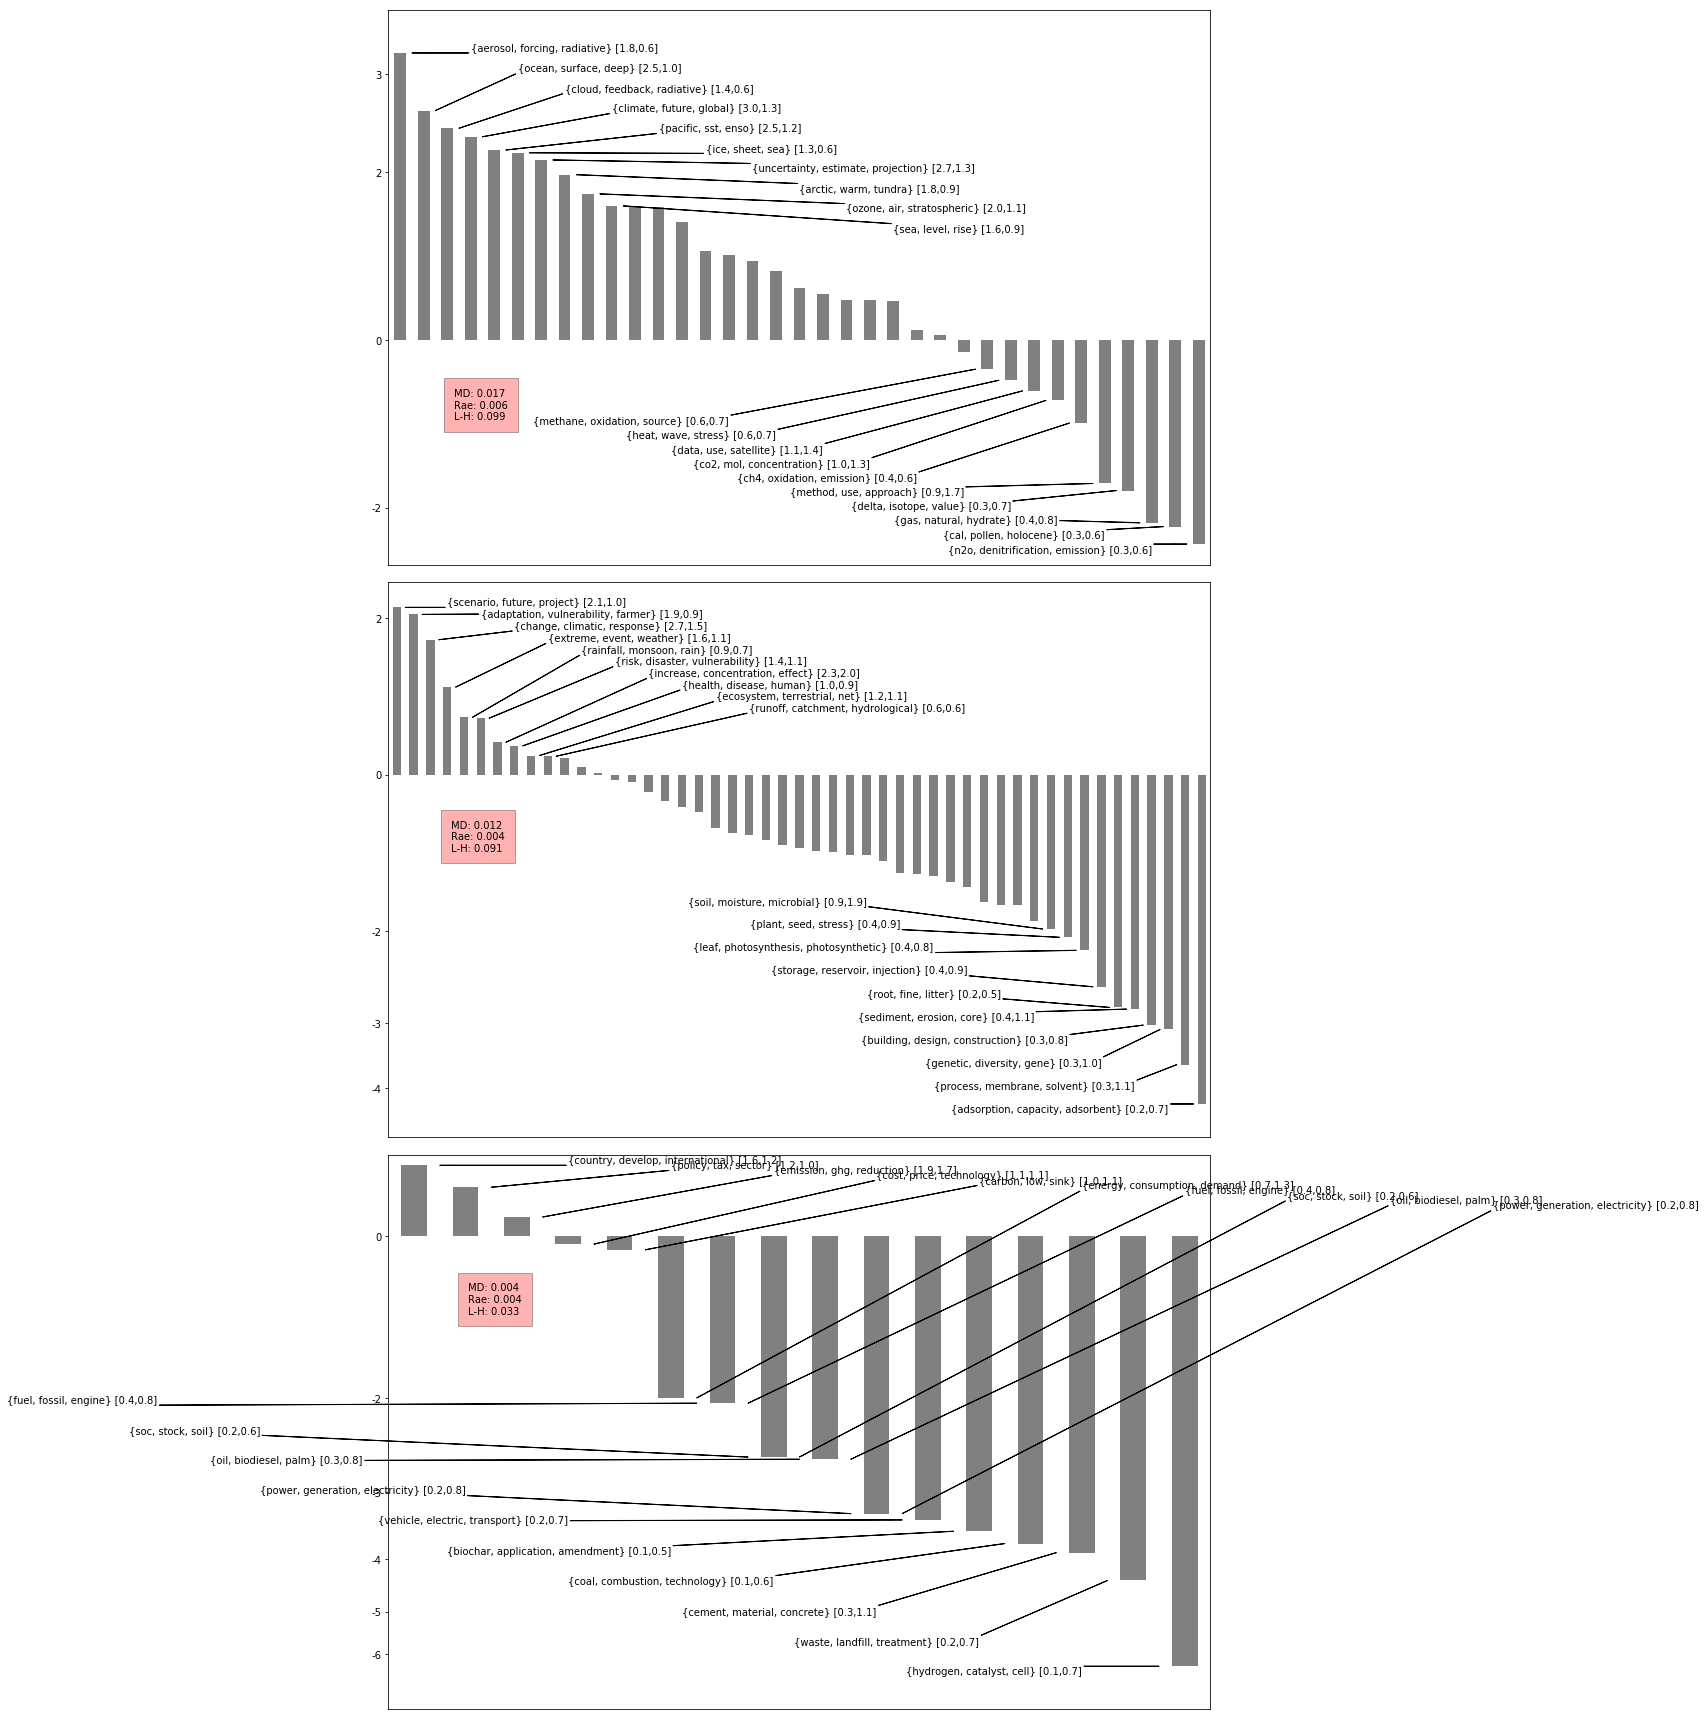

In [6]:
fig, axs = plt.subplots(3, figsize=(12,24))
for i, (name, group) in enumerate(df.groupby('primary_wg')):
    ax = axs[i]
    plot_representation(group,ax,nts=10,xspace=2,yspace=0.07)
    
plt.tight_layout()
    #plt.savefig(f'../plots/ipcc_representation/ipcc_rep_{run_id}_wg_{}.pdf',bbox_inches='tight')

In [7]:
rmin = -1.5
rmax = 1
lmin = int(1/np.exp(rmin)//1)*-1
lmax = int(np.exp(rmax)//1)

ytick_labels = [i for i in range(lmin,lmax) if i not in [-1,1]]
print(ytick_labels)
yticks = []
for x in ytick_labels:
    if x < 0:
        x = np.log(-1/x)
    elif x==0:
        x = 0
    else:
        x = np.log(x)
    yticks.append(x)
#yticks = [np.log(x) if x!=0 else 0 for x in ytick_labels ]
print(yticks)

[-4, -3, -2, 0]
[-1.3862943611198906, -1.0986122886681098, -0.6931471805599453, 0]


In [8]:
import pandas as pd
if runstat.method=="DT":

    tds = topics.filter(timedtopic__period__n__lt=6).values(
        'title','timedtopic__period__title','timedtopic__period__n','timedtopic__score','score'
    ).order_by('id','timedtopic__period__n')

    tdf = pd.DataFrame.from_dict(list(tds))

    #tdf['ys'] = tdf[]

    tdf['share'] = tdf['timedtopic__score'] / tdf['score']

    tdf['ys'] = tdf['timedtopic__period__n'] * tdf['share']


    tdf.head(12)
    #tdf.groupby('')
else:
    topic_period_scores = []
    periods = TimePeriod.objects.filter(title__regex="^AR",n__lt=6,n__gt=0).distinct('title')
    ttps = TopicTimePeriodScores.objects.filter(topic__run_id=run_id,score__isnull=False)
    if ttps.count() < (topics.count() * periods.count()-2): 
        print("calculating topictimeperiodscores")
        for p in TimePeriod.objects.filter(title__regex="^AR",n__lt=6,n__gt=0).distinct('title'):
            pdts = DocTopic.objects.filter(
                topic__run_id=run_id,
                doc__PY__in=p.ys
            ).values(
                'topic__title','topic__score'
            ).annotate(
                timedtopic__score = Sum('score')
            )
            for pdt in list(pdts):
                pdt['timedtopic__period__n'] = p.n
                t = Topic.objects.get(run_id=run_id,title=pdt['topic__title'])
                ttps, created = TopicTimePeriodScores.objects.get_or_create(
                    topic=t,
                    period=p
                )
                ttps.score = pdt['timedtopic__score']
                ttps.save()
                topic_period_scores.append(pdt)
        tdf = pd.DataFrame.from_dict(topic_period_scores)
        tdf['share'] = tdf['timedtopic__score'] / tdf['topic__score']

        tdf['ys'] = tdf['timedtopic__period__n'] * tdf['share']     
    else:
        print("getting topictimeperiodscores")
        tds = topics.filter(topictimeperiodscores__period__n__lt=6).values(
            'title','topictimeperiodscores__period__title',
            'topictimeperiodscores__period__n','topictimeperiodscores__score','score'
        ).order_by('id','topictimeperiodscores__period__n')   
        
        tdf = pd.DataFrame.from_dict(list(tds))
            
        tdf['share'] = tdf['topictimeperiodscores__score'] / tdf['score']

        tdf['ys'] = tdf['topictimeperiodscores__period__n'] * tdf['share']
    tdf = tdf.rename(columns={
        "topic__title":"title",
        "topictimeperiodscores__period__n":"timedtopic__period__n"
    }).dropna().reset_index(drop=True)
    
tdf.head()

getting topictimeperiodscores


,score,title,timedtopic__period__n,topictimeperiodscores__period__title,topictimeperiodscores__score,share,ys
0,947.235257,"{scale, spatial, variability}",1,AR1,0.766347,0.000809,0.000809
1,947.235257,"{scale, spatial, variability}",2,AR2,13.422564,0.014170,0.028341
2,947.235257,"{scale, spatial, variability}",3,AR3,41.257416,0.043556,0.130667
3,947.235257,"{scale, spatial, variability}",4,AR4,95.039430,0.100334,0.401334
4,947.235257,"{scale, spatial, variability}",5,AR5,320.632046,0.338493,1.692463


In [9]:
means = tdf.groupby('title')['ys'].mean()

means = pd.DataFrame({'ys' : tdf.groupby('title')['ys'].mean()}).reset_index()

mdf = df.merge(means)

mdf.head()

means.sort_values('ys',ascending=False).head()



,title,ys
45,"{ice, sheet, sea}",0.537693
69,"{record, glacial, late}",0.533519
8,"{cal, pollen, holocene}",0.529543
34,"{flux, measurement, surface}",0.521014
55,"{ocean, surface, deep}",0.520790


In [10]:
def year_av(x):
    group = tdf[tdf['title']==x['title']]
    l = []
    for index, y in group.iterrows():
        l = l + [y.timedtopic__period__n] * round(y.share*100)
    return np.mean(l)

mdf['year_av'] = df.apply(year_av,axis=1)

print(mdf[pd.isna(mdf['year_av'])].shape)

mdf.head()

(0, 12)


,ipcc_coverage,ipcc_score,ipcc_share,primary_wg,score,share,title,deviation,abs_md,representation,ys,year_av
0,0.038335,4.114427,0.001480,3,218.514466,0.005529,"{coal, combustion, technology}",-0.004049,0.004049,0.267688,0.464458,4.588235
1,0.150624,63.912225,0.022989,2,787.598419,0.019927,"{increase, concentration, effect}",0.003062,0.003062,1.153663,0.450162,4.431373
2,0.276211,39.111254,0.014068,1,231.722640,0.005863,"{cloud, feedback, radiative}",0.008205,0.008205,2.399568,0.492019,4.315789
3,0.127695,24.108271,0.008672,2,354.217701,0.008962,"{vegetation, ndvi, index}",-0.000290,0.000290,0.967600,0.462528,4.423077
4,0.157020,23.672996,0.008515,1,278.090374,0.007036,"{solar, radiation, irradiance}",0.001479,0.001479,1.210228,0.464374,4.423077


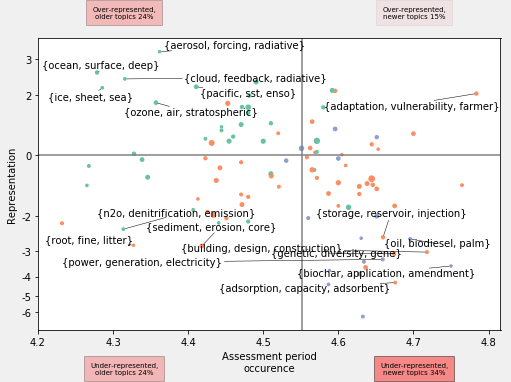

In [11]:
x = 'year_av'
y = 'representation'
y = 'lrep'

mdf['lrep'] = np.log(mdf['representation'])

fig, ax = plt.subplots()

cmap = {1: "#66c2a5", 2: "#fc8d62" , 3: "#8da0cb"}
colors = [cmap[i] for i in mdf['primary_wg']]


mdf.plot.scatter(
    x,y,s=mdf['score']*0.03,
    c = colors,ax=ax
)


# Fit a trendline
#z = np.polyfit(x=mdf[x], y=mdf[y], deg=1)
#p = np.poly1d(z)
#mdf['trendline'] = p(mdf.loc[:, x])
#plt.plot(mdf[x],mdf['trendline'])


# Quantile x and y
qs = 6
mdf['x_q'] = pd.qcut(mdf[x], qs, labels=False)
mdf['y_q'] = pd.qcut(mdf[y], qs, labels=False)
texts = []

# write texts for dots in outer quantiles
for i, row in mdf[(mdf['x_q'].isin([0,qs-1])) & (mdf['y_q'].isin([0,qs-1]))].iterrows(): 
    texts.append(plt.text(row[x],row[y],row['title'],ha='center', va='center'))
    
# Tweak the labels to avoid overlap    
adjust_text(
    texts, 
    arrowprops=dict(arrowstyle="-", color='black', lw=0.5)
)


# Split the graph into quadrants
ymid = 0
plt.axhline(ymid,c="grey")
plt.axvline(mdf[x].median(),c="grey")



# Put labels on the quadrants
# x
d1 = mdf[x].median()-plt.xlim()[0]
d2 = mdf[x].median()-plt.xlim()[1]

xlabpoints = [mdf[x].median()-d1/2,mdf[x].median()-d2/2]
xrange = mdf[x].max()-mdf[x].min()
xlabpoints = [mdf[x].min()+xrange*0.15,mdf[x].min()+xrange*0.85]
labels = [
    ['Under-represented,\nolder topics','Under-represented,\nnewer topics'],
    ['Over-represented,\nolder topics','Over-represented,\nnewer topics']
]

pylims = plt.ylim()

tpad = (pylims[1]-pylims[0])*0.13


ops = [operator.lt,operator.gt]


for i in [0,1]:
    for j in [0,1]:
        if j==0:
            tpadx=tpad*-1
        else:
            tpadx=tpad*0.66

            
        q = mdf[(ops[i](mdf[x],mdf[x].median())) & (ops[j](mdf[y],ymid))]
        qshare = q['score'].sum()/mdf['score'].sum()
        plt.text(
            xlabpoints[i],
            pylims[j]+tpadx,
            labels[j][i] + " {:.0%}".format(qshare),
            va="center",ha="center",
            bbox={'facecolor':'red', 'alpha':qshare*2-0.25, 'pad':6},
            fontsize=7
        )

        
fmax = None
fmin = None
rmax = mdf['lrep'].max()
if fmax:
    rmax = fmax
rmin = mdf['lrep'].min()
if fmin:
    rmin = -fmin
    
if rmin > -1:
    rmin = -1
if np.exp(rmax) < 2:
    rmax = np.log(2.1)

lmin = int(1/np.exp(rmin)//1)*-1
lmax = int(np.exp(rmax)//1)



ytick_labels = [i for i in range(lmin,lmax+1) if i not in [-1,1]]
yticks = []
for x in ytick_labels:
    if x < 0:
        y = np.log(-1/x)
    elif x==0:
        y = 0
    else:
        y = np.log(x)
    yticks.append(y)
    
ax.set_yticks(yticks)
ax.set_yticklabels(ytick_labels)

#ax.get_yaxis().set_visible(False)
#ax.tick_params(axis=u'both', which=u'both',length=0)
#ax2.tick_params(axis=u'both', which=u'both',length=0)
plt.xlabel('Assessment period\noccurence')
plt.ylabel('Representation')

plt.tight_layout(h_pad=100)

fig.patch.set_facecolor('#f0f0f0')    


plt.savefig(
    '../plots/ipcc_representation/ipcc_rep_new{}_all.{}'.format(run_id,extension),
    bbox_inches='tight',
    facecolor=fig.get_facecolor(),
    pad_inches=0.2
)

plt.show()

In [12]:
mdf.to_csv(f'../tables/newness_representation_{run_id}.csv',index=False)

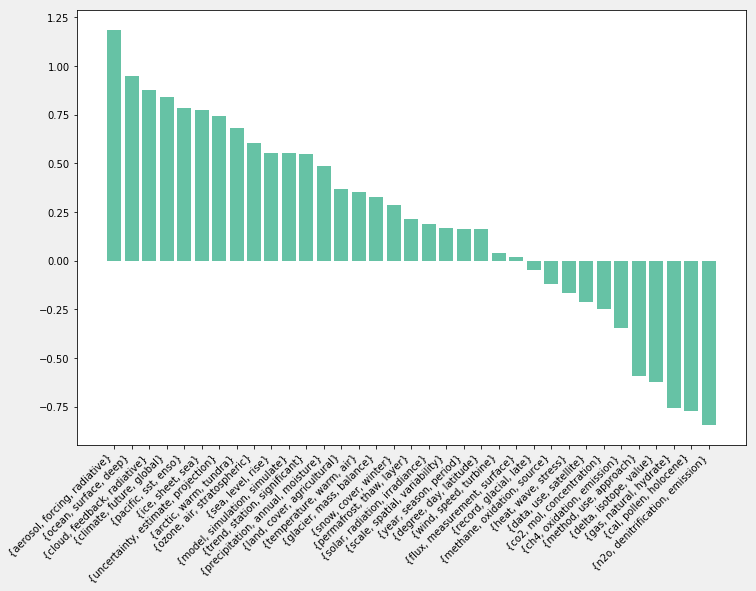

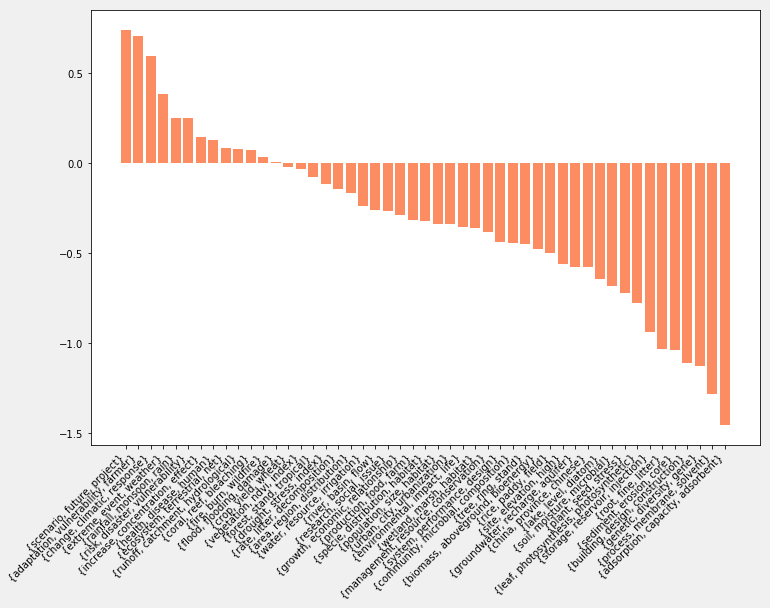

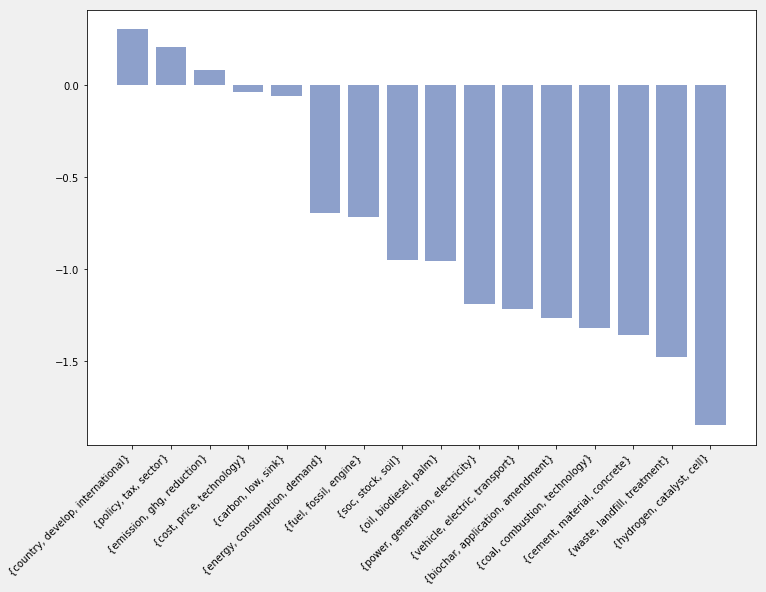

In [13]:
for name, group in mdf.groupby('primary_wg'):
    group = group.sort_values('lrep', ascending=False).reset_index(drop=True)
    fig, ax = plt.subplots(figsize=(12,8))
    
    #plot_representation(group,ax,nts=10,xspace=2,yspace=0.07)
    plt.xticks(rotation=45,ha="right")
    ax.bar(group.index, group['lrep'], color=cmap[group['primary_wg'][0]])
    ax.set_xticks(group.index)
    ax.set_xticklabels(group['title'])
    fig.patch.set_facecolor('#f0f0f0') 
    
    plt.savefig(
        '../plots/ipcc_representation/ipcc_rep_wg_{}_{}_all.{}'.format(name,run_id,extension),
        bbox_inches='tight',
        facecolor=fig.get_facecolor(),
        pad_inches=0.2
    )
    
    plt.show()
    

In [14]:
plt.close()

In [15]:
mdf.sort_values('year_av', ascending=False).tail(15)

,ipcc_coverage,ipcc_score,ipcc_share,primary_wg,score,share,title,deviation,abs_md,representation,ys,year_av,lrep,x_q,y_q
27,0.250151,70.699265,0.025430,1,458.229130,0.011594,"{pacific, sst, enso}",0.013837,0.013837,2.193472,0.501731,4.410714,0.785486,0,5
66,0.064709,9.724114,0.003498,1,257.669996,0.006519,"{delta, isotope, value}",-0.003022,0.003022,0.536520,0.519472,4.406780,-0.622651,0,1
74,0.349269,51.101292,0.018381,1,221.727346,0.005610,"{aerosol, forcing, radiative}",0.012771,0.012771,3.276517,0.507934,4.362069,1.186781,0,5
37,0.207455,56.103374,0.020180,1,436.048399,0.011032,"{ozone, air, stratospheric}",0.009148,0.009148,1.829170,0.495976,4.357143,0.603862,0,5
70,0.101513,28.196277,0.010142,1,514.587981,0.013020,"{co2, mol, concentration}",-0.002877,0.002877,0.778990,0.451803,4.346154,-0.249757,0,2
48,0.106162,30.836346,0.011092,1,460.008839,0.011639,"{record, glacial, late}",-0.000547,0.000547,0.953008,0.533519,4.338710,-0.048132,0,3
73,0.115016,29.273795,0.010530,1,408.470599,0.010335,"{flux, measurement, surface}",0.000195,0.000195,1.018868,0.521014,4.327869,0.018693,0,3
94,0.047195,4.867906,0.001751,2,193.613829,0.004899,"{root, fine, litter}",-0.003148,0.003148,0.357442,0.472451,4.327273,-1.028782,0,0
2,0.276211,39.111254,0.014068,1,231.722640,0.005863,"{cloud, feedback, radiative}",0.008205,0.008205,2.399568,0.492019,4.315789,0.875289,0,5
64,0.059309,7.595075,0.002732,1,251.157648,0.006355,"{n2o, denitrification, emission}",-0.003623,0.003623,0.429918,0.446829,4.313725,-0.844161,0,0


In [16]:
mdf = mdf.sort_values(['primary_wg','year_av'],ascending=False).reset_index(drop=True)

mdf.head()

mdf[['ipcc_share','share','representation','primary_wg','title','year_av']].to_latex(
    '../tables/ipcc_shares_time.tex',
    index_names=False,
)

In [17]:
q = runstat.query
colors = ['#7fc97f','#beaed4','#fdc086','#ffff99','#386cb0','#f0027f','#F0F0F0']

oecd_cats = [
    {'wc__oecd': 'Agricultural Sciences'},
    {'wc__oecd': 'Engineering and Technology'},
    {'wc__oecd': 'Humanities'},
    {'wc__oecd': 'Medical and Health Sciences'},
    {'wc__oecd': 'Natural Sciences'},
    {'wc__oecd': 'Social Sciences'},
    #{'wc__oecd': None}
]

d_count = Doc.objects.filter(query=q,PY__lte=AR.objects.get(ar=5).end).count()

ip_d_count = Doc.objects.filter(query=q, ipccref__isnull=False).count()

oecd_df = pd.DataFrame()
for i,c in enumerate(oecd_cats):
    ds = Doc.objects.filter(
        query=q,
        wc__oecd=c['wc__oecd'],
        PY__lte=AR.objects.get(ar=5).end
    )
    ipds = ds.filter(ipccref__isnull=False)
    c['share'] = ds.count() / d_count
    c['ipcc_share'] = ipds.count() / ip_d_count
    c['color'] = colors[i]
    
oecd_df = pd.DataFrame.from_dict(oecd_cats)

oecd_df.head()

,color,ipcc_share,share,wc__oecd
0,#7fc97f,0.046736,0.107608,Agricultural Sciences
1,#beaed4,0.066614,0.247342,Engineering and Technology
2,#fdc086,0.001372,0.007933,Humanities
3,#ffff99,0.018232,0.019410,Medical and Health Sciences
4,#386cb0,0.806116,0.701151,Natural Sciences


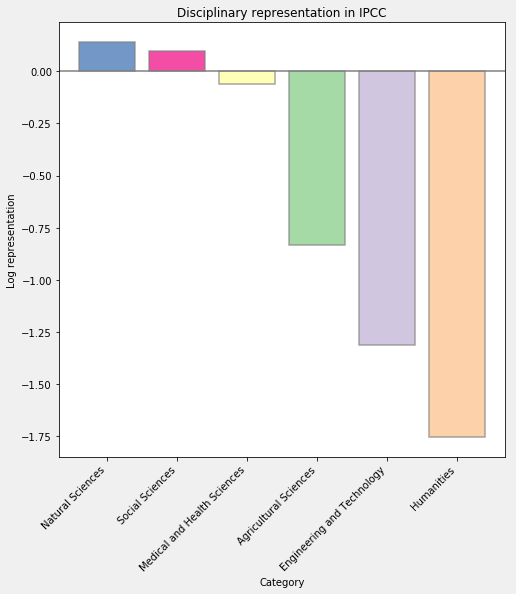

In [18]:
oecd_df['representation'] = oecd_df['ipcc_share'] / oecd_df['share']

oecd_df['lrep'] = np.log(oecd_df['representation'])

oecd_df = oecd_df.sort_values('representation', ascending=False).reset_index(drop=True)

fig, ax = plt.subplots(figsize=(8,8))

ax.bar(
    oecd_df.index, 
    oecd_df['lrep'],
    color=oecd_df['color'],
    alpha=0.7,
    linewidth=1.5,
    edgecolor="grey"
)

ax.set_xticks(oecd_df.index)
ax.set_xticklabels(oecd_df['wc__oecd'])

ax.set_xlabel('Category')
ax.set_ylabel('Log representation')

ax.axhline(0,c="grey")

ax.set_title("Disciplinary representation in IPCC")

plt.xticks(rotation=45,ha="right")

fig.patch.set_facecolor('#f0f0f0')    


In [19]:
q = runstat.query
colors = ['#7fc97f','#beaed4','#fdc086','#ffff99','#386cb0','#f0027f','#F0F0F0']
oecd_cats = [
    {'wc__oecd': 'Agricultural Sciences'},
    {'wc__oecd': 'Engineering and Technology'},
    {'wc__oecd': 'Humanities'},
    {'wc__oecd': 'Medical and Health Sciences'},
    {'wc__oecd': 'Natural Sciences'},
    {'wc__oecd': 'Social Sciences'},
    {'wc__oecd': None}
]



oecd_df = pd.DataFrame()

ar_oe_cats = []

all_docs_count =  Doc.objects.filter(query=q).count()

for ar in AR.objects.filter(ar__gt=0,ar__lt=6).order_by('ar'):
    print(ar)
    ys = range(ar.start,ar.end+1)
    d_count = Doc.objects.filter(query=q, PY__in=ys).count()
    ip_d_count = Doc.objects.filter(query=q, PY__in=ys, ipccref__isnull=False).count()
    for i,c in enumerate(oecd_cats):
        d = {"wc__oecd": c["wc__oecd"]}
        ds = Doc.objects.filter(
            query=q,
            wc__oecd=c['wc__oecd'],
            PY__in=ys,
            PY__lte=AR.objects.get(ar=5).end
        )
        ipds = ds.filter(ipccref__isnull=False)
        all_ars_share = Doc.objects.filter(query=q,wc__oecd=c['wc__oecd']).count() / all_docs_count
        d['ar'] = ar.ar
        d['share'] = ds.count() / d_count
        d['ipcc_share'] = ipds.count() / ip_d_count
        d['color'] = colors[i]
        d['total_share'] = all_ars_share
        
        ar_oe_cats.append(d)

oecd_df_ys = pd.DataFrame.from_dict(ar_oe_cats)

oecd_df_ys.head()

1
2
3
4
5


,ar,color,ipcc_share,share,total_share,wc__oecd
0,1,#7fc97f,0.021429,0.095973,0.102866,Agricultural Sciences
1,1,#beaed4,0.014286,0.093402,0.260545,Engineering and Technology
2,1,#fdc086,0.000000,0.023136,0.009045,Humanities
3,1,#ffff99,0.000000,0.018852,0.018990,Medical and Health Sciences
4,1,#386cb0,0.978571,0.899743,0.658729,Natural Sciences


In [20]:
oecd_df_ys['representation'] = oecd_df_ys['ipcc_share'] / oecd_df_ys['share']

oecd_df_ys.sort_values('representation').head(15)

,ar,color,ipcc_share,share,total_share,wc__oecd,representation
34,5,#F0F0F0,0.000000,0.000469,0.001772,None,0.000000
2,1,#fdc086,0.000000,0.023136,0.009045,Humanities,0.000000
3,1,#ffff99,0.000000,0.018852,0.018990,Medical and Health Sciences,0.000000
5,1,#f0027f,0.000000,0.044559,0.101383,Social Sciences,0.000000
6,1,#F0F0F0,0.000000,0.002571,0.001772,None,0.000000
16,3,#fdc086,0.000000,0.005894,0.009045,Humanities,0.000000
9,2,#fdc086,0.000000,0.003982,0.009045,Humanities,0.000000
27,4,#F0F0F0,0.000147,0.001316,0.001772,None,0.111837
1,1,#beaed4,0.014286,0.093402,0.260545,Engineering and Technology,0.152949
30,5,#fdc086,0.001921,0.008823,0.009045,Humanities,0.217752


/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


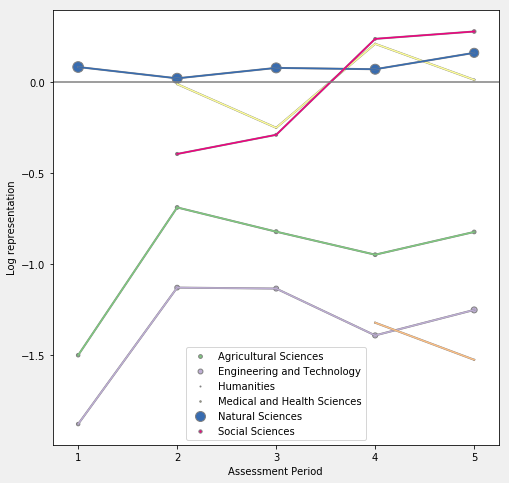

In [21]:
fig, ax = plt.subplots(figsize=(8,8))

oecd_df_ys['lrep'] = np.log(oecd_df_ys['representation'])

fdf = oecd_df_ys

fdf['ar_share_total'] = fdf.groupby('ar')['share'].transform('sum')

for name, group in fdf.groupby('wc__oecd'):
    color = group.reset_index()['color'][0]
    group['s_share'] = group['share'] / group['ar_share_total']
    ax.plot(
        group['ar'],
        group['lrep'],
        label='_nolegend_',
        lw=2,
        color="grey"
    )
    ax.plot(
        group['ar'],
        group['lrep'],
        #label=name,
        label='_nolegend_',
        color=color
    )
    ax.scatter(
        group['ar'],
        group['lrep'],
        label=name,
        color=color,
        s = 150*group['s_share'],
        edgecolor="grey"
    )
    
    ax.set_xticks([1,2,3,4,5])
    
ax.axhline(0,c="grey")
    
plt.legend()


ax.set_xlabel('Assessment Period')
ax.set_ylabel('Log representation')

fig.patch.set_facecolor('#f0f0f0')    

plt.savefig(
    '../plots/ipcc_representation/ipcc_rep_oecds_time.{}'.format(extension),
    bbox_inches='tight',
    facecolor=fig.get_facecolor(),
    pad_inches=0.2
)


In [22]:
cats = list(WC.objects.distinct('oecd_fos_text').values('oecd_fos_text','oecd_fos','oecd'))
cats

[{'oecd': 'Agricultural Sciences',
  'oecd_fos': '4',
  'oecd_fos_text': 'Agriculture, forestry, and fisheries'},
 {'oecd': 'Agricultural Sciences',
  'oecd_fos': '4',
  'oecd_fos_text': 'Animal and dairy science'},
 {'oecd': 'Humanities',
  'oecd_fos': '6',
  'oecd_fos_text': 'Art (arts, history of arts, performing arts, music)'},
 {'oecd': 'Medical and Health Sciences',
  'oecd_fos': '3',
  'oecd_fos_text': 'Basic medicine'},
 {'oecd': 'Natural Sciences',
  'oecd_fos': '1',
  'oecd_fos_text': 'Biological sciences'},
 {'oecd': 'Engineering and Technology',
  'oecd_fos': '2',
  'oecd_fos_text': 'Chemical engineering'},
 {'oecd': 'Natural Sciences',
  'oecd_fos': '1',
  'oecd_fos_text': 'Chemical sciences'},
 {'oecd': 'Engineering and Technology',
  'oecd_fos': '2',
  'oecd_fos_text': 'Civil engineering'},
 {'oecd': 'Medical and Health Sciences',
  'oecd_fos': '3',
  'oecd_fos_text': 'Clinical medicine'},
 {'oecd': 'Natural Sciences',
  'oecd_fos': '1',
  'oecd_fos_text': 'Computer and 

In [23]:
q = runstat.query
colors = ['#386cb0','#beaed4','#ffff99','#7fc97f','#f0027f','#fdc086','#F0F0F0']

d_count = Doc.objects.filter(query=q,PY__lte=AR.objects.get(ar=5).end).count()

ip_d_count = Doc.objects.filter(query=q, ipccref__isnull=False).count()

oecd_df = pd.DataFrame()
for i,c in enumerate(cats):
    ds = Doc.objects.filter(
        query=q,
        wc__oecd_fos_text=c['oecd_fos_text'],
        PY__lte=AR.objects.get(ar=5).end
    )
    ipds = ds.filter(ipccref__isnull=False)
    c['share'] = ds.count() / d_count
    c['ipcc_share'] = ipds.count() / ip_d_count
    c['color'] = colors[int(c['oecd_fos'])-1]
    
    
cat_df = pd.DataFrame.from_dict(cats)

cat_df.head()

,color,ipcc_share,oecd,oecd_fos,oecd_fos_text,share
0,#7fc97f,0.038541,Agricultural Sciences,4,"Agriculture, forestry, and fisheries",0.089628
1,#7fc97f,0.001725,Agricultural Sciences,4,Animal and dairy science,0.005297
2,#fdc086,0.000039,Humanities,6,"Art (arts, history of arts, performing arts, m...",0.002002
3,#ffff99,0.000784,Medical and Health Sciences,3,Basic medicine,0.002486
4,#386cb0,0.120055,Natural Sciences,1,Biological sciences,0.184301


/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


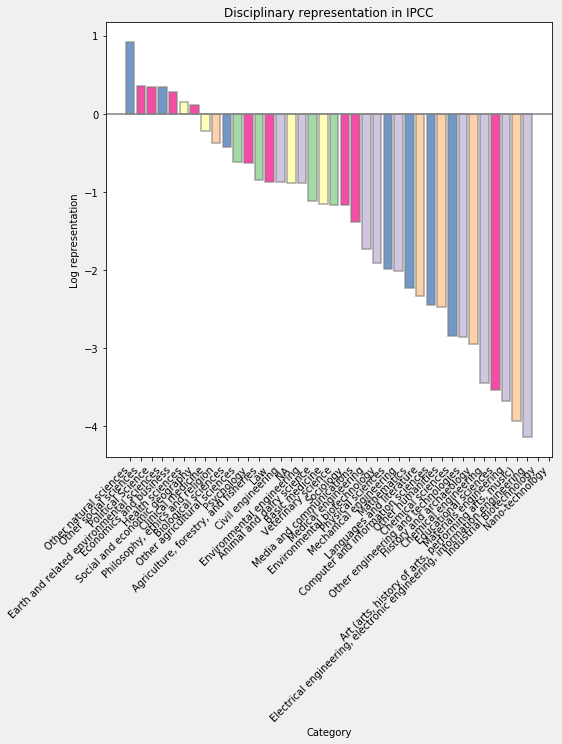

In [24]:
cat_df['representation'] = cat_df['ipcc_share'] / cat_df['share']

cat_df['lrep'] = np.log(cat_df['representation'])

cat_df = cat_df.sort_values('representation', ascending=False).reset_index(drop=True)

fig, ax = plt.subplots(figsize=(8,8))

ax.bar(
    cat_df.index, 
    cat_df['lrep'],
    alpha=0.7,
    linewidth=1.5,
    edgecolor="grey",
    color=cat_df['color']
)

ax.set_xticks(cat_df.index)
ax.set_xticklabels(cat_df['oecd_fos_text'])

ax.set_xlabel('Category')
ax.set_ylabel('Log representation')

ax.axhline(0,c="grey")

ax.set_title("Disciplinary representation in IPCC")

plt.xticks(rotation=45,ha="right")

fig.patch.set_facecolor('#f0f0f0')    


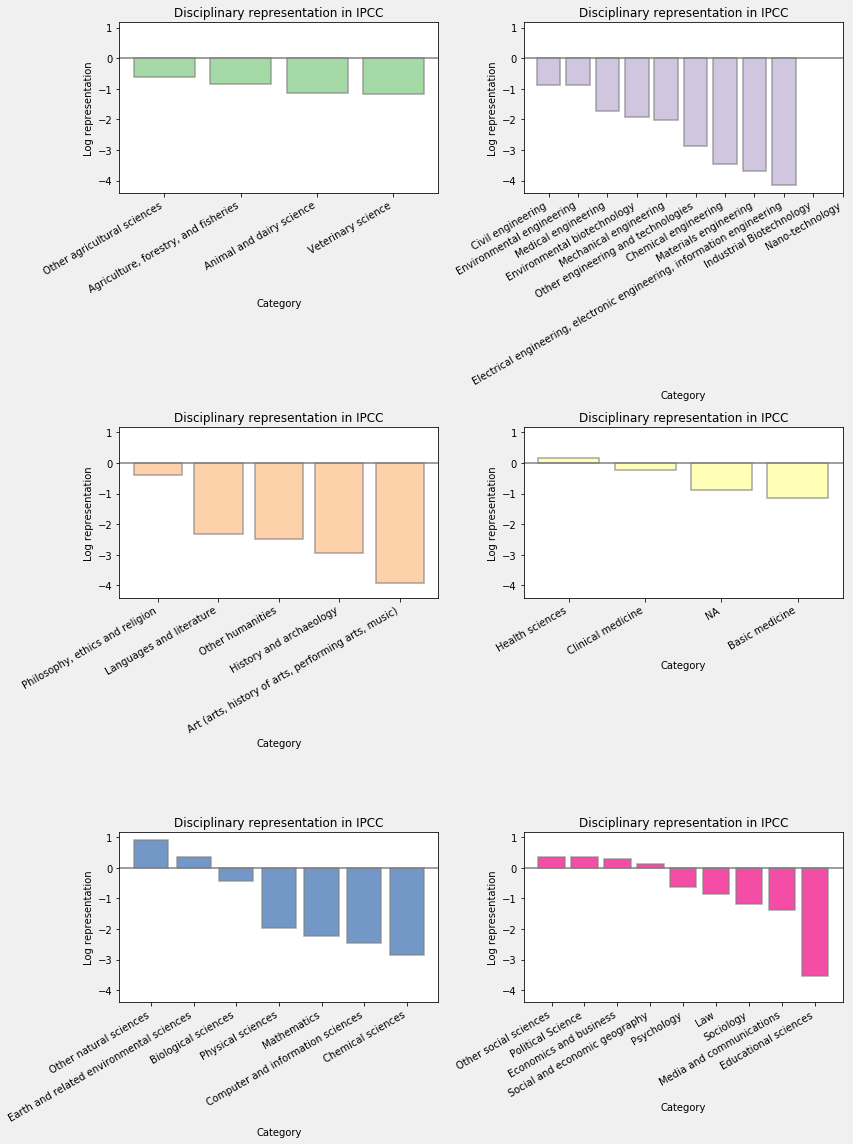

In [25]:
fig = plt.figure(figsize=(12,16))

ax = None

for i, (name, group) in enumerate(cat_df.groupby('oecd')):
    if ax:
        ax = fig.add_subplot(3,2,i+1, sharey=ax)
    else:
        ax = fig.add_subplot(3,2,i+1)
    group = group.reset_index(drop=True)
    ax.bar(
        group.index, 
        group['lrep'],
        alpha=0.7,
        linewidth=1.5,
        edgecolor="grey",
        color=group['color']
    )

    ax.set_xticks(group.index)
    ax.set_xticklabels(group['oecd_fos_text'])
    

    ax.set_xlabel('Category')
    ax.set_ylabel('Log representation')

    ax.axhline(0,c="grey")

    ax.set_title("Disciplinary representation in IPCC")

    plt.xticks()

    fig.patch.set_facecolor('#f0f0f0')    

    plt.setp(ax.get_xticklabels(), rotation=30, ha="right")
fig.tight_layout()


plt.savefig(
    f'../plots/ipcc_representation/ipcc_subcats.{extension}',
    bbox_inches='tight',
    facecolor=fig.get_facecolor(),
    pad_inches=0.2
)

In [26]:
q = runstat.query

cat_df = pd.DataFrame()

ar_cats = []

for ar in AR.objects.filter(ar__gt=0,ar__lt=6).order_by('ar'):
    print(ar)
    ys = range(ar.start,ar.end+1)
    d_count = Doc.objects.filter(query=q, PY__in=ys).count()
    ip_d_count = Doc.objects.filter(query=q, PY__in=ys, ipccref__isnull=False).count()
    for i,c in enumerate(cats):
        d = {"oecd_fos_text": c["oecd_fos_text"]}
        ds = Doc.objects.filter(
            query=q,
            wc__oecd_fos_text=c['oecd_fos_text'],
            PY__in=ys,
            PY__lte=AR.objects.get(ar=5).end
        )
        ipds = ds.filter(ipccref__isnull=False)
        d['oecd'] = c['oecd']
        d['ar'] = ar.ar
        d['share'] = ds.count() / d_count
        d['ipcc_share'] = ipds.count() / ip_d_count
        d['color'] = colors[int(c['oecd_fos'])-1]
        
        
        ar_cats.append(d)

cat_df_ys = pd.DataFrame.from_dict(ar_cats)

cat_df_ys.head()

1
2
3
4
5


,ar,color,ipcc_share,oecd,oecd_fos_text,share
0,1,#7fc97f,0.021429,Agricultural Sciences,"Agriculture, forestry, and fisheries",0.083119
1,1,#7fc97f,0.000000,Agricultural Sciences,Animal and dairy science,0.003428
2,1,#fdc086,0.000000,Humanities,"Art (arts, history of arts, performing arts, m...",0.000857
3,1,#ffff99,0.000000,Medical and Health Sciences,Basic medicine,0.003428
4,1,#386cb0,0.042857,Natural Sciences,Biological sciences,0.069409


In [27]:
cat_df_ys['representation'] = cat_df_ys['ipcc_share'] / cat_df_ys['share']

cat_df_ys.sort_values('representation').head(15)

,ar,color,ipcc_share,oecd,oecd_fos_text,share,representation
49,2,#386cb0,0.0,Natural Sciences,Computer and information sciences,0.002459,0.0
59,2,#fdc086,0.0,Humanities,Languages and literature,0.000351,0.0
58,2,#beaed4,0.0,Engineering and Technology,Industrial Biotechnology,0.000351,0.0
57,2,#fdc086,0.0,Humanities,History and archaeology,0.001405,0.0
110,3,#fdc086,0.0,Humanities,Other humanities,0.000691,0.0
178,5,#beaed4,0.0,Engineering and Technology,Industrial Biotechnology,0.000312,0.0
54,2,#beaed4,0.0,Engineering and Technology,Environmental biotechnology,0.002459,0.0
60,2,#f0027f,0.0,Social Sciences,Law,0.000468,0.0
53,2,#beaed4,0.0,Engineering and Technology,"Electrical engineering, electronic engineering...",0.007963,0.0
139,4,#fdc086,0.0,Humanities,Languages and literature,0.000129,0.0


In [28]:
fdf['share'].sum()

5.932811184871515

/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/ipykernel_la

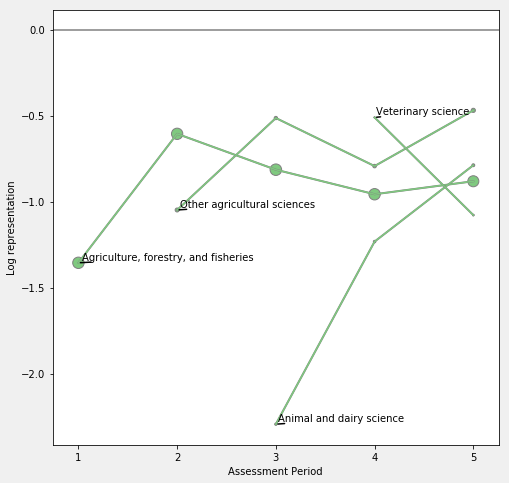

/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

empty group


/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

empty group


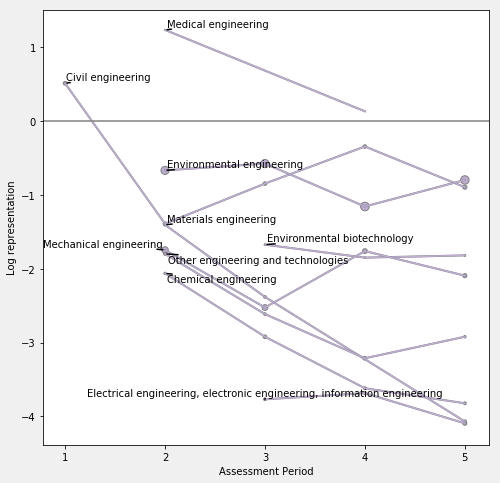

/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

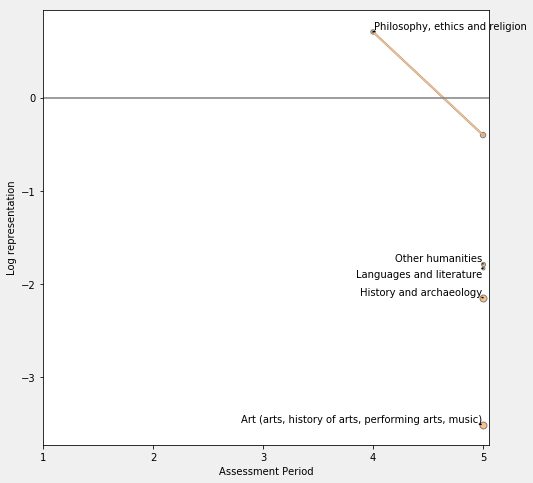

/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

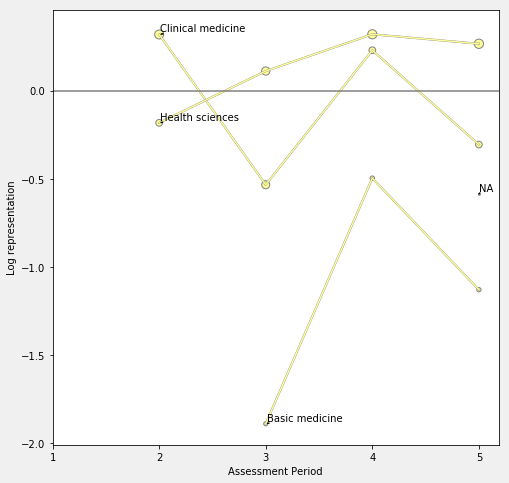

/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

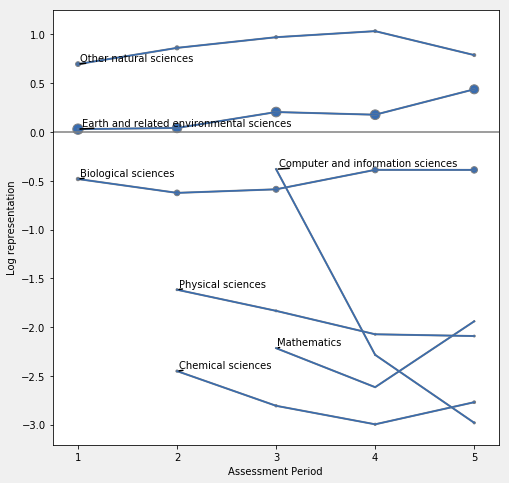

/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

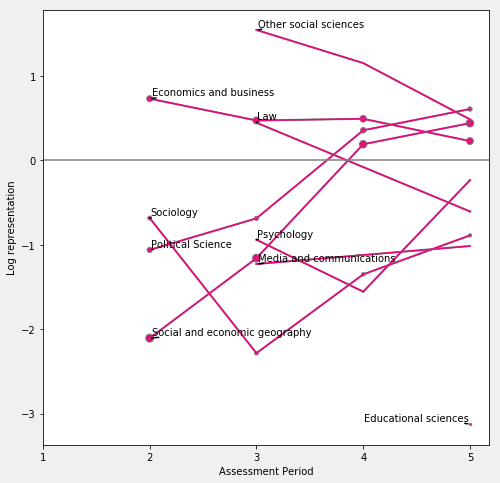

In [29]:

cat_df_ys['lrep'] = np.log(cat_df_ys['representation'])


for dis, fdf in cat_df_ys.groupby('oecd'):
    fig, ax = plt.subplots(figsize=(8,8))
    texts = []
    fdf['ar_share_total'] = fdf.groupby('ar')['share'].transform('sum')
    
    for name, group in fdf.groupby('oecd_fos_text'):
        group['s_share'] = group['share'] / group['ar_share_total']
        group = group[np.isfinite(group['lrep'])].sort_values('ar').reset_index(drop=True)
        
        if len(group) == 0:
            print("empty group")
            continue

        color = group.reset_index()['color'][0]
        ax.plot(
            group['ar'],
            group['lrep'],
            label='_nolegend_',
            lw=2,
            color="grey"
        )
        ax.plot(
            group['ar'],
            group['lrep'],
            label=name,
            color=color
        )
        ax.scatter(
            group['ar'],
            group['lrep'],
            label=name,
            color=color,
            s = 150*group['s_share'],
            edgecolor="grey"
        )
        x = group['ar'][0] 
        y = group['lrep'][0]
        if np.isfinite(y):
            texts.append(
            ax.text(
                x,y,
                name
            )
            )

    adjust_text(
        texts, 
        arrowprops=dict(arrowstyle="-", color='black', lw=1.5)
    )

    ax.set_xticks([1,2,3,4,5])

    ax.axhline(0,c="grey")

    #plt.legend()


    ax.set_xlabel('Assessment Period')
    ax.set_ylabel('Log representation')

    fig.patch.set_facecolor('#f0f0f0')    

    plt.savefig(
        f'../plots/ipcc_representation/ipcc_rep_cats_time_{dis}.{extension}',
        bbox_inches='tight',
        facecolor=fig.get_facecolor(),
        pad_inches=0.2
    )
    
    plt.show()
    plt.close()


/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


Humanities (0.9%)
Medical and Health Sciences (1.9%)
Social Sciences (10.1%)
Agricultural Sciences (10.3%)
Engineering and Technology (26.1%)
Natural Sciences (65.9%)


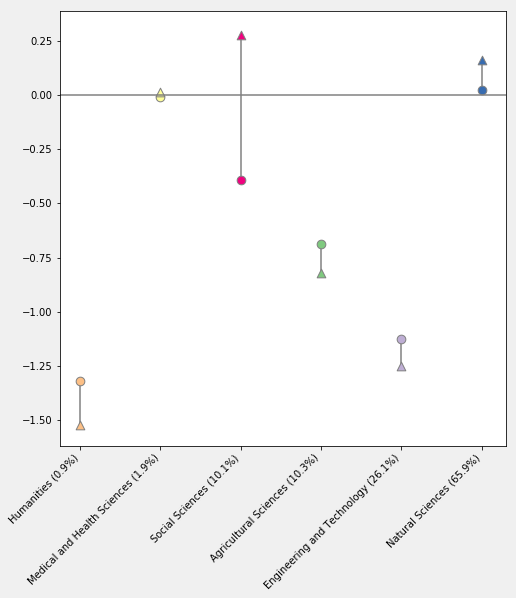

In [30]:
fig, ax = plt.subplots(figsize=(8,8))

oecd_df_ys['lrep'] = np.log(oecd_df_ys['representation'])

fdf = oecd_df_ys[oecd_df_ys['ar']>1]

fdf['ar_share_total'] = fdf.groupby('ar')['share'].transform('sum')


ticks = []
labels = []

for i, (name, group) in enumerate(fdf.sort_values('total_share').groupby('wc__oecd', sort=False)):
    group = group.replace(-np.inf, np.nan).dropna().sort_values('ar').reset_index(drop=True)
    name = f"{name} ({group['total_share'][0]:.1%})"
    print(name)
    ticks.append(i)
    labels.append(name)
    color = group.reset_index()['color'][0]
    group['s_share'] = group['share'] / group['ar_share_total']
    
    start = group['lrep'][0]
    end = group['lrep'][len(group)-1]
    size = 75
    ax.plot(
        [i,i],
        [start,end],
        color="grey",
        zorder=-50
    )
    ax.scatter(
        i,
        start,
        label=name,
        color=color,
        s = size,
        edgecolor="grey",
        #marker="x"
    )
    ax.scatter(
        i,
        end,
        label=name,
        color=color,
        s = size,
        edgecolor="grey",
        marker="^"
    )
    
    
ax.set_xticks(ticks)
ax.set_xticklabels(labels, ha="right", rotation=45)
ax.axhline(0,c="grey")

fig.patch.set_facecolor('#f0f0f0') 


plt.savefig(
    '../plots/ipcc_representation/ipcc_rep_oecds_simplified.{}'.format(extension),
    bbox_inches='tight',
    facecolor=fig.get_facecolor(),
    pad_inches=0.2
)


plt.show()



In [31]:
fdf.sort_values('total_share')

,ar,color,ipcc_share,share,total_share,wc__oecd,representation,lrep,ar_share_total
20,3,#F0F0F0,0.000216,0.000967,0.001772,None,0.223347,-1.499030,1.193866
27,4,#F0F0F0,0.000147,0.001316,0.001772,None,0.111837,-2.190709,1.188692
13,2,#F0F0F0,0.000805,0.001757,0.001772,None,0.457978,-0.780934,1.204239
34,5,#F0F0F0,0.000000,0.000469,0.001772,None,0.000000,-inf,1.167779
9,2,#fdc086,0.000000,0.003982,0.009045,Humanities,0.000000,-inf,1.204239
16,3,#fdc086,0.000000,0.005894,0.009045,Humanities,0.000000,-inf,1.193866
30,5,#fdc086,0.001921,0.008823,0.009045,Humanities,0.217752,-1.524400,1.167779
23,4,#fdc086,0.001619,0.006064,0.009045,Humanities,0.266982,-1.320574,1.188692
24,4,#ffff99,0.017663,0.014296,0.018990,Medical and Health Sciences,1.235460,0.211444,1.188692
31,5,#ffff99,0.022654,0.022348,0.018990,Medical and Health Sciences,1.013728,0.013635,1.167779
